In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))
from pydicom.data import get_testdata_file
from pipeline.dicom_io import dicom_to_tensor
from pipeline import preprocess as pp
import matplotlib.pyplot as plt
import torch

In [2]:
path = get_testdata_file("CT_small.dcm")
timg, ds = dicom_to_tensor(path, window_center=40, window_width=400, device="cuda")
print("tensor:", timg.shape, timg.min().item(), timg.max().item())

tensor: torch.Size([1, 1, 128, 128]) 0.0 1.0


In [3]:
img_np = timg[0,0].detach().cpu().numpy()

enh = pp.enhance_pipeline(
    img_np,
    denoise="bilateral",
    denoise_params={"d": 7, "sigma_color": 35.0, "sigma_space": 3.0},
    do_clahe=True,
    clahe_params={"clip_limit": 2.0, "tile_grid_size": (8,8)},
    do_unsharp=True,
    unsharp_params={"ksize": 3, "sigma": 0.0, "amount": 0.8},
    do_clip=True,
    clip_params={"low_q": 0.005, "high_q": 0.995},
    do_gamma=False,
)

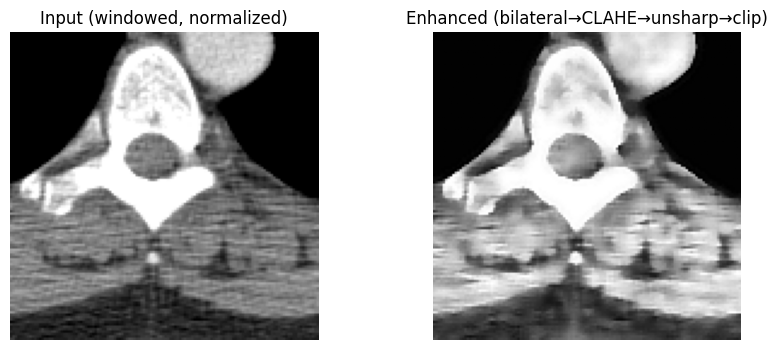

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(img_np, cmap="gray"); ax[0].set_title("Input (windowed, normalized)"); ax[0].axis("off")
ax[1].imshow(enh,   cmap="gray"); ax[1].set_title("Enhanced (bilateral→CLAHE→unsharp→clip)"); ax[1].axis("off")
plt.show()

In [5]:
enh_only_clahe = pp.enhance_pipeline(
    timg,
    denoise="none",
    denoise_params=None,
    do_clahe=True,
    clahe_params={"clip_limit": 2.0, "tile_grid_size": (8,8)},
    do_unsharp=False,
    unsharp_params=None,
    do_clip=False,
    clip_params=None,
    do_gamma=False,
)

enh_triton_clahe = pp.enhance_pipeline_triton(
    timg,
    do_clahe=True,
    clahe_params={"clip_limit": 2.0, "tile_grid_size": (8,8)}
)

Debug: Tile Size=(16x16), Clip Limit Val=2


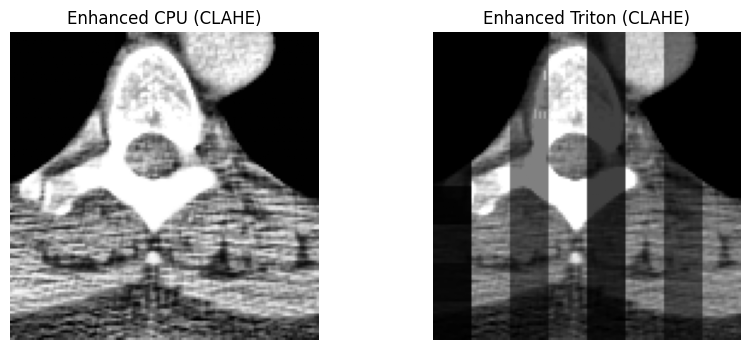

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(enh_only_clahe, cmap="gray"); ax[0].set_title("Enhanced CPU (CLAHE)"); ax[0].axis("off")
ax[1].imshow(enh_triton_clahe[0,0], cmap="gray"); ax[1].set_title("Enhanced Triton (CLAHE)"); ax[1].axis("off")
plt.show()

MSE (Mean Squared Error): 82693.609332
PSNR: -49.17 dB
SSIM: 0.015802 (1.0 = 완전 동일)
MAE (Mean Absolute Error): 200.243652
Max Difference: 759.000000


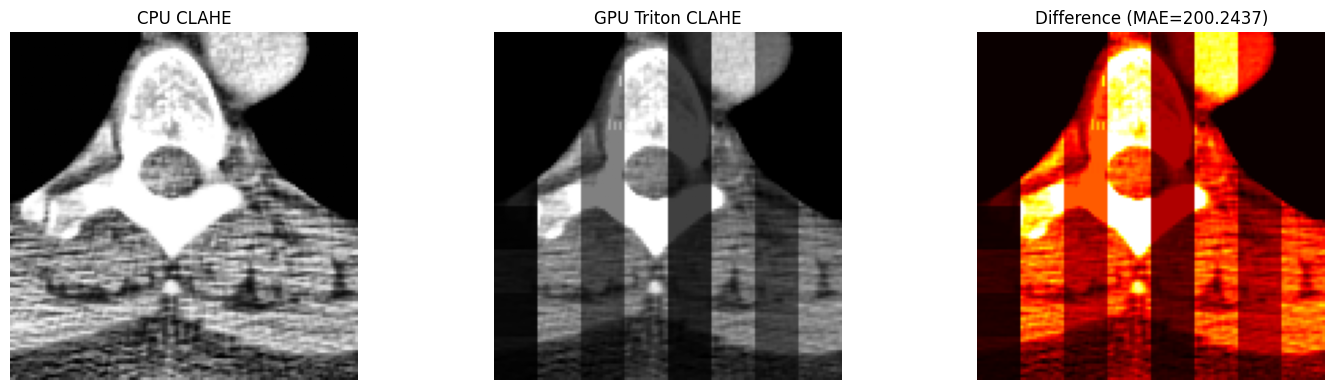

In [7]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import numpy as np

# 두 이미지를 numpy 배열로 변환 (동일 형식)
cpu_img = enh_only_clahe
gpu_img = enh_triton_clahe[0, 0]

# 1. Mean Squared Error (MSE)
mse = mean_squared_error(cpu_img, gpu_img)
print(f"MSE (Mean Squared Error): {mse:.6f}")

# 2. Peak Signal-to-Noise Ratio (PSNR)
if mse > 0:
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # [0,1] 범위 기준
    print(f"PSNR: {psnr:.2f} dB")
else:
    print("PSNR: inf (이미지 동일)")

# 3. Structural Similarity Index (SSIM) - 0~1, 1이 동일
ssim_score = ssim(cpu_img, gpu_img, data_range=1.0)
print(f"SSIM: {ssim_score:.6f} (1.0 = 완전 동일)")

# 4. 픽셀 차이 절대값 평균 (MAE)
mae = np.mean(np.abs(cpu_img - gpu_img))
print(f"MAE (Mean Absolute Error): {mae:.6f}")

# 5. 최대 차이
max_diff = np.max(np.abs(cpu_img - gpu_img))
print(f"Max Difference: {max_diff:.6f}")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(cpu_img, cmap="gray"); axes[0].set_title("CPU CLAHE")
axes[1].imshow(gpu_img, cmap="gray"); axes[1].set_title("GPU Triton CLAHE")
diff_img = np.abs(cpu_img - gpu_img)
axes[2].imshow(diff_img, cmap="hot"); axes[2].set_title(f"Difference (MAE={mae:.4f})")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()